In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".2"

import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit, lax, grad, value_and_grad

from neuron import h
_ = h.load_file("stdlib.hoc")

from neurax.integrate import solve
from neurax.cell import Cell
from neurax.stimulus import Stimulus, step_current
from neurax.recording import Recording

In [3]:
device_str = "cpu"
jax.config.update('jax_platform_name', device_str)

cpus = jax.devices("cpu")
gpus = jax.devices("gpu")

device = cpus[0] if device_str == "cpu" else gpus[0]

# JAX

### Define model

In [11]:
num_cells = 1
nseg_per_branch = 16
num_branches = 15
ncomp = num_branches * nseg_per_branch
parents = jnp.asarray([-1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6])

assert len(parents) == num_branches
params_single_cell = [0.12, 0.036, 0.0003] * ncomp
params = jnp.asarray([params_single_cell] * num_cells)
init_single_cell = [-62.0, 0.074901, 0.4889, 0.3644787]*num_branches*nseg_per_branch
u = jnp.asarray([init_single_cell] * num_cells)

length = 100.0  # um (length of a single branch)
radius = 10.0  # um
r_a = 10_000  # ohm cm 
i_delay = 5.0  # ms
i_amp = 1.0  # nA
i_dur = 2.0  # ms
dt = 0.025  # ms
t_max = 20.0  # ms

### Set up model

In [12]:
time_vec = jnp.arange(0, t_max+dt, dt)

In [13]:
cells = [Cell(num_branches, parents, nseg_per_branch, length, radius, r_a)] * num_cells

stims = [
    Stimulus(cell_ind=0, branch_ind=0, loc=0.0, current=step_current(i_delay, i_dur, i_amp, time_vec)),
    Stimulus(cell_ind=1, branch_ind=0, loc=0.0, current=step_current(i_delay, i_dur, i_amp, time_vec)),
]
recs = [
    Recording(0, 0, 0.0),
    Recording(0, 6, 1.0),
    Recording(1, 0, 0.0),
    Recording(1, 6, 1.0),
    Recording(3, 0, 0.0),
    Recording(3, 6, 1.0),
    Recording(4, 0, 0.0),
    Recording(4, 6, 1.0),
]
# conn = Connection(cell, 0, 0.0, cell, 15, 1.0)  # Excitatory feedback: soma -> tuft.

### Run solver

In [15]:
start_time = time.time()
s = solve(cells, u, params, stims, recs, t_max=t_max, dt=dt)
print("Time: ", time.time() - start_time)

Time:  0.024591445922851562


### Vis

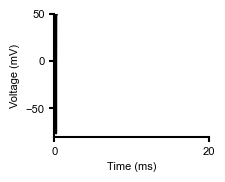

In [17]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, num_cells, figsize=(num_cells * 2, 1.6))
    ax = np.atleast_1d(ax)
    for i in range(num_cells):
        _ = ax[i].plot(time_vec, s[i], c="k")

    _ = ax[0].set_xlabel("Time (ms)")
    _ = ax[0].set_ylabel("Voltage (mV)")
    
    for a in ax[1:]:
        a.set_yticklabels([])
    for a in ax:
        _ = a.set_ylim([-80, 50])
        a.set_xticks([0, 20])
        a.set_xlim([0, 20])
    plt.show()

# NEURON

In [15]:
soma = h.Section()
denda1 = h.Section()
denda2 = h.Section()
dendb1 = h.Section()
dendb2 = h.Section()
dendc1 = h.Section()
dendc2 = h.Section()
dendc3 = h.Section()
dendc4 = h.Section()

denda1.connect(soma, 1, 0)
denda2.connect(soma, 1, 0)
dendb1.connect(denda1, 1, 0)
dendb2.connect(denda1, 1, 0)
dendc1.connect(dendb1, 1, 0)
dendc2.connect(dendb1, 1, 0)
dendc3.connect(dendb2, 1, 0)
dendc4.connect(dendb2, 1, 0)

__nrnsec_0x2b4dd9d0

In [16]:
stim = h.IClamp(soma(0.0))
stim.delay = i_delay
stim.dur = i_dur
stim.amp = i_amp

voltage_soma = h.Vector()
voltage_soma.record(soma(0.0)._ref_v)

voltage_somaend = h.Vector()
voltage_somaend.record(soma(1.0)._ref_v)

voltage_dend1 = h.Vector()
voltage_dend1.record(denda1(1.0)._ref_v)

voltage_dend4 = h.Vector()
voltage_dend4.record(dendb2(1.0)._ref_v)

voltage_dend6 = h.Vector()
voltage_dend6.record(dendc1(1.0)._ref_v)

voltage_dend7 = h.Vector()
voltage_dend7.record(dendc2(1.0)._ref_v)

Vector[11]

In [17]:
for sec in h.allsec():
    sec.insert("hh")
    sec.L = length
    sec.nseg = nseg_per_branch
    sec.diam = radius * 2
    sec.Ra = r_a
    
    sec.gnabar_hh = 0.120  # S/cm2
    sec.gkbar_hh = 0.036  # S/cm2
    sec.gl_hh = 0.0003  # S/cm2
    sec.ena = 50  # mV
    sec.ek = -77.0  # mV
    sec.el_hh = -54.3  # mV

In [18]:
h.dt = dt
tstop = 20.0
v_init = -62.0
def initialize():
    h.finitialize(v_init)
    h.fcurrent()
    
def integrate():
    while h.t < tstop:
        h.fadvance()

In [19]:
initialize()
integrate()

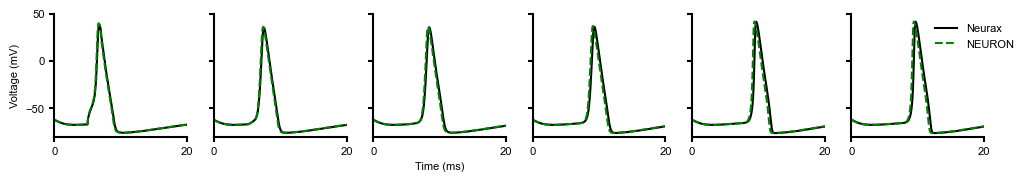

In [20]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 6, figsize=(12, 1.6))
    for i in range(6):
        _ = ax[i].plot(time_vec, s[i], c="k")

    _ = ax[0].plot(time_vec, list(voltage_soma)[:-1], c="g", linestyle="--")
    _ = ax[1].plot(time_vec, list(voltage_somaend)[:-1], c="g", linestyle="--")
    _ = ax[2].plot(time_vec, list(voltage_dend1)[:-1], c="g", linestyle="--")
    _ = ax[3].plot(time_vec, list(voltage_dend4)[:-1], c="g", linestyle="--")
    _ = ax[4].plot(time_vec, list(voltage_dend6)[:-1], c="g", linestyle="--")
    _ = ax[5].plot(time_vec, list(voltage_dend7)[:-1], c="g", linestyle="--")

    _ = ax[2].set_xlabel("Time (ms)")
    _ = ax[0].set_ylabel("Voltage (mV)")
    
    for a in ax[1:]:
        a.set_yticklabels([])
    for a in ax:
        _ = a.set_ylim([-80, 50])
        a.set_xticks([0, 20])
        a.set_xlim([0, 20])
    ax[5].legend(["Neurax", "NEURON"], loc="upper right", bbox_to_anchor=[1.3, 1.0, 0.0, 0.0])
    plt.savefig("../../results/neurax_vs_neuron_acc.png", dpi=200, bbox_inches="tight")
    plt.show()